# Include input image handling and handle non-dog images

In [3]:
# Import Libraries

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import concurrent.futures
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [5]:
# Specify the number of breeds
num_breeds = 60
im_size = 224
batch_size = 64
encoder = LabelEncoder()

In [6]:
# Read the CSV file
df_labels = pd.read_csv("/content/drive/MyDrive/Breed_Identification/labels.csv")

# Store training and testing images folder locations
train_file = '/content/drive/MyDrive/Breed_Identification/train/'
test_file = '/content/drive/MyDrive/Breed_Identification/test/'

# Check the total number of unique breeds in our dataset file
print("Total number of unique Dog Breeds:", len(df_labels.breed.unique()))

Total number of unique Dog Breeds: 120


In [7]:
# Get only 60 unique breeds records
breed_dict = list(df_labels['breed'].value_counts().keys())
new_list = sorted(breed_dict, reverse=True)[:num_breeds * 2 + 1:2]
# Change the dataset to have only those 60 unique breed records
df_labels = df_labels.query('breed in @new_list')
# Create a new column that will contain image names with the image extension
df_labels['img_id'] = df_labels['id'].apply(lambda x: x + ".jpg")

In [8]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is not None:
        print(f"Loading image: {img_path}")
        img = cv2.resize(img, (im_size, im_size))
        img_array = preprocess_input(np.expand_dims(np.array(img).astype(np.float32), axis=0))
        return img_array
    else:
        print(f"Failed to load image: {img_path}")
        return None
num_workers = 10
# Use ThreadPoolExecutor for parallel image loading
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    image_paths = [train_file + img_id for img_id in df_labels['img_id']]
    loaded_images = list(executor.map(load_and_preprocess_image, image_paths))

# Convert the list of loaded images to a numpy array
train_x = np.array(loaded_images, dtype='float32')

Streaming output truncated to the last 5000 lines.
Loading image: /content/drive/MyDrive/Breed_Identification/train/087b211f15ad8095ba90c0be54c1c30d.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/08644ddaf5a3ca7f08fcab7561ec4eea.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/0861355ea326a82de3aab420d4276e5b.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/080ec59213ed7425b7f8c169955bb9d0.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/08829c00da02dea80eb491122989492f.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/0891ce3700686a8df5b4bd711be44ea9.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/08af52c888b0f5735c3ced810771601d.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/08946697b3e50e602d6bea765c8fb9f5.jpg
Loading image: /content/drive/MyDrive/Breed_Identification/train/08e4013c0ddc710c57d1d188bf7c0cfe.jpg
Loading image: /content/drive/M

In [11]:
# Convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

# Split the dataset in an 80:20 ratio for training and testing
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [12]:
# Add an extra dimension to x_train
x_train = np.expand_dims(x_train, axis=0)
# Remove the extra dimension from x_train
x_train = x_train.squeeze()

# Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Generate images for the training set
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

In [13]:
# Image augmentation for the testing set
# Add an extra dimension to x_train
x_test = np.expand_dims(x_test, axis=0)
# Remove the extra dimension from x_train
x_test = x_test.squeeze()
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [24]:
# Build the model using InceptionV3
with tf.device('/GPU:0'):
    inception = InceptionV3(input_shape=(im_size, im_size, 3), include_top=False, weights='imagenet')
    for layer in inception.layers[:-10]:  # Fine-tune the last 10 layers
        layer.trainable = False

    x = inception.output
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)  # Adjust dropout rate
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)  # Adjust dropout rate
    predictions = Dense(num_breeds, activation='softmax')(x)

    model = Model(inputs=inception.input, outputs=predictions)

In [29]:
def lr_schedule(epoch):
    if epoch < 20:
        return 1e-4
    elif 20 <= epoch < 40:
        return 1e-5
    else:
        return 1e-6

# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with the learning rate schedule
optimizer = RMSprop(learning_rate=1e-3, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
# Train the model with early stopping and learning rate schedule
model.fit(train_generator, steps_per_epoch=x_train.shape[0] // batch_size,
          epochs=epochs, validation_data=test_generator,
          validation_steps=x_test.shape[0] // batch_size,
          callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule), early_stopping])

# Save the model
model.save("dog_identification.h5")

Epoch 1/50
64/64 [==============================] - 52s 739ms/step - loss: 2.1191 - accuracy: 0.5118 - val_loss: 1.3625 - val_accuracy: 0.6689 - lr: 1.0000e-04
Epoch 2/50
64/64 [==============================] - 48s 747ms/step - loss: 2.0746 - accuracy: 0.5157 - val_loss: 1.2792 - val_accuracy: 0.6904 - lr: 1.0000e-04
Epoch 3/50
64/64 [==============================] - 48s 743ms/step - loss: 1.9331 - accuracy: 0.5316 - val_loss: 1.2578 - val_accuracy: 0.6924 - lr: 1.0000e-04
Epoch 4/50
64/64 [==============================] - 49s 757ms/step - loss: 1.9157 - accuracy: 0.5339 - val_loss: 1.2267 - val_accuracy: 0.7002 - lr: 1.0000e-04
Epoch 5/50
13/64 [=====>........................] - ETA: 35s - loss: 1.9072 - accuracy: 0.5357

1/1 [==============================] - 1s 1s/step


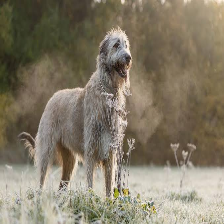

Predicted Breed for this Dog is: scottish_deerhound


In [19]:
# Load the model
model = load_model("dog_identification.h5")

# Get the image of the dog for prediction
pred_img_path = '/content/irish.jpeg'
pred_img_array = cv2.resize(cv2.imread(pred_img_path, cv2.IMREAD_COLOR), (im_size, im_size))
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array).astype(np.float32), axis=0))

# Predict the breed
pred_val = model.predict(np.array(pred_img_array, dtype="float32"))
cv2_imshow(cv2.resize(cv2.imread(pred_img_path, cv2.IMREAD_COLOR), (im_size, im_size)))

pred_breed = encoder.inverse_transform([np.argmax(pred_val)])[0]
# Check if the prediction confidence is below a threshold (you can adjust this threshold)
confidence_threshold = 0.3

if np.max(pred_val) < confidence_threshold:
    print("The submitted image is not a dog.")
else:
    print("Predicted Breed for this Dog is:", pred_breed)